In [1]:
from fitparse import FitFile
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error
import numpy as np

Import .fit file as pandas data frame

In [2]:
fit = FitFile("../data/Stryd 68kg 181cm backgarden 1km.fit")
# fit = FitFile("../data/stryd-up-n-down.fit")

def record_to_series(record):
    return pd.Series({f.name: f.value for f in record.fields})

df = pd.DataFrame([record_to_series(record) for record in fit.get_messages("record")]).drop(["position_lat", "position_long", "distance", "heart_rate", "enhanced_altitude", "enhanced_speed", "speed", "Form Power"], axis=1)

Absolute altitude and distance are not useful for our purposes. However, changes of altitude and distance over time might be important features. 

In [3]:
df.loc[:,"altitude_diff"] = df.altitude.diff()
df.loc[:,"distance_diff"] = df.Distance.diff()
df.drop(["altitude", "Distance"], axis=1, inplace=True)
df = df.dropna()

# Correlation

We explore what features correlate to power -- our target variable

Observations:
* The strongest positive correlations to power can be seen for cadence, vertical oscillation \[amplitude\], leg spring stiffness and speed.
* Air power shows strong negative correlation with changes in altitude (probably due to the direction of the wind)

TODO remove silence


,power,cadence,vertical_oscillation,stance_time,Air Power,Leg Spring Stiffness,Speed,altitude_diff,distance_diff
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,196.077889,68.384422,67.505025,234.989950,2.150754,7.292714,2.657310,0.006533,2.608040
std,95.118944,31.321289,37.002672,137.811008,1.852872,4.206613,1.311730,0.116444,1.839159
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.400000,0.000000
25%,193.000000,80.000000,74.000000,234.000000,1.000000,4.750000,2.579102,0.000000,2.000000
50%,227.500000,83.000000,81.000000,250.000000,2.000000,9.500000,3.097656,0.000000,2.000000
75%,252.000000,83.000000,84.000000,265.500000,3.000000,9.875000,3.354492,0.000000,4.000000
max,374.000000,97.000000,169.000000,968.000000,9.000000,11.625000,5.515625,0.200000,7.000000


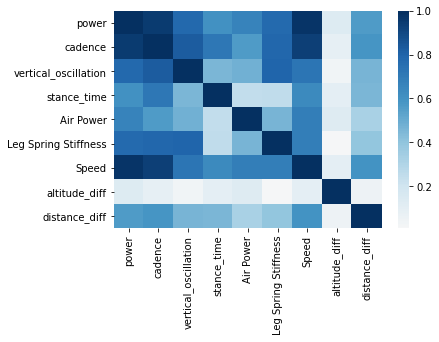

In [4]:
display(df.describe())
sns.heatmap(df.corr(), cmap="RdBu", center=0.0)
plt.show()

# Modelling
## Helper functions

For the purpose of our experiments we perform 5-fold cross validation, to get less biased performance metrics.

In [5]:
def get_cv_stats(reg, X, y, name=""):
    cv = pd.DataFrame(cross_validate(reg, X, y, scoring=['r2', 'neg_mean_absolute_error']))
    return pd.Series({
        "mae_mean": cv.test_neg_mean_absolute_error.mean(),
        "mae_std": cv.test_neg_mean_absolute_error.std(),
        "r2_mean": cv.test_r2.mean(),
        "r2_std": cv.test_r2.std(),
    }, name=name)

def get_cv_mae(reg_class, alpha, X, y):
    reg = reg_class(alpha=alpha)
    return get_cv_stats(reg, X, y).mae_mean

## Preprocessing
* Separate the features (`X`) and the target (`y`)
* Some ML models benefit from features being uniformly scaled, hence Standard Scaler is applied (`X_scaled` and `y_scaled`)
* From physical models, we know that power is not related to speed linearly, but rather to a square of speed. Therefore, we can transform our features into combinations of polynomial terms (with degree up to 2) -- `X_polynomial`
* In addition, `X_selected` contains hand picked features. Cadence, vertical oscillation, stance time and speed are the features that can be approximated from accelerometer data, and should be relevant for power calculations.

In [6]:
X = df.iloc[:,2:]
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
X_selected = X_scaled.loc[:,["cadence", "vertical_oscillation", "stance_time", "Speed"]]

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_polynomial = poly_features.fit_transform(X_scaled)
feature_names = list(poly_features.get_feature_names())
for i, x in enumerate(X.columns):
    feature_names = [y.replace(f"x{i}", x) for y in feature_names]
X_polynomial = pd.DataFrame(X_polynomial, columns=feature_names)

y = df.iloc[:,1]
y_scaled = StandardScaler().fit_transform(y.values.reshape(-1,1)).reshape(-1,)
# y_scaled = StandardScaler().fit_transform(y)

## Linear Regression
It's the simplest regression model, that fits `y=sum(w_i * x_i) + b` minimising sum of square difference between the predicted and the target values.

Note on the performance metrics:
* Negative mean absolute error (MAE) -- higher values (or lower absolute values) are better
* R^2 score -- coefficient of determination, a proportion of the target variance that can be predicted from the input features. Values closer to 1.0 are better

Fitting the regression with the basic set of features, does a good job, with R^2 of 0.803

In [7]:
lr_naive_cv_summary = get_cv_stats(LinearRegression(), X_scaled, y_scaled, "Linear")
lr_naive_cv_summary

mae_mean   -0.151143
mae_std     0.042484
r2_mean     0.803620
r2_std      0.324110
Name: Linear, dtype: float64

Fitting with only the selected features makes the performance worse (even though not greatly), with R^2 of 0.772

In [8]:
lr_manual_cv_summary = get_cv_stats(LinearRegression(), X_selected, y_scaled, "Linear (selected)")
lr_manual_cv_summary

mae_mean   -0.157931
mae_std     0.055153
r2_mean     0.772471
r2_std      0.370952
Name: Linear (selected), dtype: float64

Using the polynomial features, the performance gets even worse with R^2 of 0.691

In [9]:
lr_poly_cv_summary = get_cv_stats(LinearRegression(), X_polynomial, y_scaled, "Linear (polynomial)")
lr_poly_cv_summary

mae_mean   -0.233588
mae_std     0.065597
r2_mean     0.690869
r2_std      0.295533
Name: Linear (polynomial), dtype: float64

## Ridge regression
Ridge regression can be used to attempt improving performance of the ordinary linear regression. In addition to minimising the square error, Ridge introduces a penalty for the size of the coefficients (L2 regularisation).

As opposed to the ordinary Linear Regression, Ridge requires a parameter for weight penalty (alpha). We try a range of different alpha values, and pick one that gives the best MAE on cross-validation.

However, we can see that any alpha greater than 0, decreases the performance of a model fitted on the original set of features.  

<AxesSubplot:>

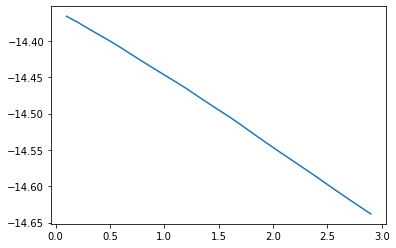

In [10]:
alpha = np.arange(0.1,3.0,0.1)
mae = [get_cv_mae(Ridge, x, X_scaled, y) for x in alpha]
sns.lineplot(alpha, mae)

In [11]:
ridge_cv_summary = get_cv_stats(Ridge(0.1), X, y, "Ridge")
ridge_cv_summary

mae_mean   -14.365137
mae_std      4.050783
r2_mean      0.803202
r2_std       0.325014
Name: Ridge, dtype: float64

Fitting Ridge with polynomial features gives the best performance for alpha = 7.1, however R^2 is still lower than for the plain linear model. 

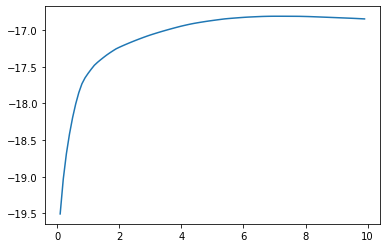

7.1

In [12]:
alpha = np.arange(0.1,10.0,0.1)
mae = [get_cv_mae(Ridge, x, X_polynomial, y) for x in alpha]
sns.lineplot(alpha, mae)
plt.show()
best_alpha = alpha[np.argmax(mae)]
best_alpha

In [13]:
ridge_poly_cv_summary = get_cv_stats(Ridge(best_alpha), X_polynomial, y, "Ridge (Polynomial)")
ridge_poly_cv_summary

mae_mean   -16.812178
mae_std      2.945713
r2_mean      0.765870
r2_std       0.344874
Name: Ridge (Polynomial), dtype: float64

## Lasso Regression
Another improvement over the ordinary Linear Regression is Lasso. It employs L1 reguralisation, that penalises non-zero coefficients, effectively acting as feature selection.

Same as Ridge, it requires an alpha parameter.

Using the original features, we get the optimal value of alpha = 0.37, and R^2 of 0.806, which is marginally better than our original model.

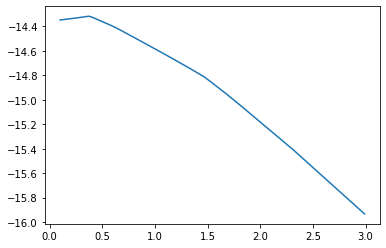

0.3699999999999999

In [14]:
alpha = np.arange(0.1,3.0,0.01)
mae = [get_cv_mae(Lasso, x, X_scaled, y) for x in alpha]
sns.lineplot(alpha, mae)
plt.show()
best_alpha = alpha[np.argmax(mae)]
best_alpha

In [15]:
lasso_cv_summary = get_cv_stats(Lasso(best_alpha), X_scaled, y_scaled, "Lasso")
lasso_cv_summary

mae_mean   -0.421793
mae_std     0.318050
r2_mean     0.330418
r2_std      0.882556
Name: Lasso, dtype: float64

Observing the coefficients, Lasso Regression model uses only vertical oscillation, leg spring stiffness, speed, and change in altitude to estimate the power.

In [16]:
coef = pd.Series(Lasso(best_alpha).fit(X_scaled, y_scaled).coef_, index=X_scaled.columns)
coef[coef.abs() > 0]

cadence    0.128379
Speed      0.482425
dtype: float64

Applying the same procedure to the polynomial features and alpha = 0.54, the performance is on par with the original model.

/home/dlowl/git/wearable-my-foot/notebooks/env/lib64/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 572.0701948627684, tolerance: 284.5708330188679
  model = cd_fast.enet_coordinate_descent(
/home/dlowl/git/wearable-my-foot/notebooks/env/lib64/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.1065784066086, tolerance: 328.59329278996876
  model = cd_fast.enet_coordinate_descent(
/home/dlowl/git/wearable-my-foot/notebooks/env/lib64/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 954.8194515579962, tolerance: 324.89973354231984
  model = cd_fast.enet_coordinate_descent(
/home

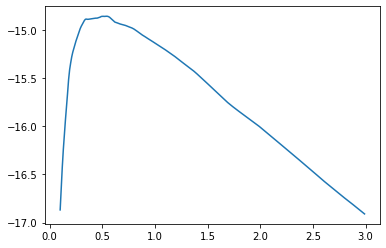

0.5399999999999998

In [17]:
alpha = np.arange(0.1,3.0,0.01)
mae = [get_cv_mae(Lasso, x, X_polynomial, y) for x in alpha]
sns.lineplot(alpha, mae)
plt.show()
best_alpha = alpha[np.argmax(mae)]
best_alpha

In [18]:
lasso_poly_cv_summary = get_cv_stats(Lasso(best_alpha), X_polynomial, y, "Lasso (Polynomial)")
lasso_poly_cv_summary

mae_mean   -14.859122
mae_std      2.959187
r2_mean      0.803971
r2_std       0.318593
Name: Lasso (Polynomial), dtype: float64

The highest weight is given to speed. However, it is unexpected for the square of cadence to have a large negative weight

In [19]:
coef = pd.Series(Lasso(best_alpha).fit(X_polynomial, y).coef_, index=X_polynomial.columns)
coef[coef.abs() > 0]

vertical_oscillation                   0.450955
Air Power                              2.283172
Leg Spring Stiffness                   6.065354
Speed                                 65.319887
altitude_diff                          3.855482
distance_diff                         -0.046320
cadence^2                            -11.229774
cadence stance_time                   -1.517464
vertical_oscillation^2                -0.249014
vertical_oscillation Air Power        -0.791379
vertical_oscillation altitude_diff     1.681120
stance_time^2                         -1.223993
stance_time altitude_diff             -1.108581
stance_time distance_diff             -0.019814
Air Power^2                           -0.285644
Air Power altitude_diff               -0.097108
Leg Spring Stiffness^2                -3.507196
Leg Spring Stiffness altitude_diff     0.644023
Speed^2                                2.950054
Speed altitude_diff                    0.936915
dtype: float64

In [20]:
mlp_summary = get_cv_stats(MLPRegressor(hidden_layer_sizes=(1000,)), X_scaled, y_scaled, "MLP")
mlp_summary

mae_mean   -0.161521
mae_std     0.025931
r2_mean     0.797577
r2_std      0.325061
Name: MLP, dtype: float64

In [21]:
mlp_poly_summary = get_cv_stats(MLPRegressor(hidden_layer_sizes=(len(X_polynomial)*2)), X_polynomial, y_scaled, "MLP (polynomial)")
mlp_poly_summary

mae_mean   -0.183335
mae_std     0.020825
r2_mean     0.767670
r2_std      0.329473
Name: MLP (polynomial), dtype: float64

In [22]:
pd.DataFrame([
    lr_naive_cv_summary, lr_manual_cv_summary, lr_poly_cv_summary,
    ridge_cv_summary, ridge_poly_cv_summary,
    lasso_cv_summary, lasso_poly_cv_summary,
    mlp_summary, mlp_poly_summary
])

,mae_mean,mae_std,r2_mean,r2_std
Linear,-0.151143,0.042484,0.803620,0.324110
Linear (selected),-0.157931,0.055153,0.772471,0.370952
Linear (polynomial),-0.233588,0.065597,0.690869,0.295533
Ridge,-14.365137,4.050783,0.803202,0.325014
Ridge (Polynomial),-16.812178,2.945713,0.765870,0.344874
Lasso,-0.421793,0.318050,0.330418,0.882556
Lasso (Polynomial),-14.859122,2.959187,0.803971,0.318593
MLP,-0.161521,0.025931,0.797577,0.325061
MLP (polynomial),-0.183335,0.020825,0.767670,0.329473
